# Кодирование категориальных признаков. 
В большинстве задач интеллектуального анализа наши наборы данных будут содержать категориальные признаки. Категориальные признаки содержат конечное число дискретных значений. То, как мы представим эти признаки в значительной степени повлияет на производительность будущей модели. Как и в других аспектах машинного обучения, здесь нет серебряных пуль. Определение правильного подхода, специфичного для нашей модели и данных, является частью проблемы.

В этом руководстве рассматриваются некоторые из методов кодирования категориальных переменных. Мы начнем с описания простой техники, прежде чем приступить к более сложным, менее известным подходам.

Список охватываемых методов:
- One-Hot Encoding
- Feature Hashing
- Binary Encoding
- Target Encoding
- Weight of Evidence

In [7]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount = True)

# Подключаем библиотеки и загружаем набор данных

In [8]:
!pip install category_encoders

Defaulting to user installation because normal site-packages is not writeable


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import os
import warnings

warnings.simplefilter(action = 'ignore', category = FutureWarning)

Загружаем набор данных.

Где я его взял? Тут: https://www.kaggle.com/uciml/adult-census-income

Информация о целевой переменной (income): <=50K или > 50K

In [10]:
path = "adult.csv"            # Иногда могут быть проблемы с кирилицей в названиях папок на пути к файлу, постарайтесь всегда использовтаь только латиницу.
data = pd.read_csv(path, sep = ",")                               # Путь к файлу можно записать как отдельно, так и внутри метода read_csv.

In [11]:
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [12]:
data["sex"].value_counts()

Male      21790
Female    10771
Name: sex, dtype: int64

In [13]:
data["native.country"].value_counts()

United-States                 29170
Mexico                          643
?                               583
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        64
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
Greece                      

In [14]:
data.shape

(32561, 15)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [16]:
y = data["income"]
train = data.drop(["income"], axis = 1)

In [17]:
object_list_feature = list(train.select_dtypes(include = 'object').columns)

In [18]:
y.value_counts()

<=50K    24720
>50K      7841
Name: income, dtype: int64

#Для примеров на пальцах

In [19]:
pd.options.display.float_format = '{:.2f}'.format # to make legible

# make some data
df = pd.DataFrame({
    'color':["a", "c", "a", "a", "b", "b"], 
    'outcome':[1, 2, 0, 0, 0, 1]})

# set up X and y
X = df.drop('outcome', axis = 1)
X_res = df.drop('outcome', axis = 1)
y1 = df.drop('color', axis = 1)
df

,color,outcome
0,a,1
1,c,2
2,a,0
3,a,0
4,b,0
5,b,1


# Classic Encoders

In [20]:
from sklearn.preprocessing import LabelEncoder

In [21]:
le = LabelEncoder()
encoded = le.fit_transform(np.ravel(X))    # warning thrown without np.ravel

In [22]:
X_res["LabelEncoder"] = encoded

In [23]:
X_res

,color,LabelEncoder
0,a,0
1,c,2
2,a,0
3,a,0
4,b,1
5,b,1


# Как будем сравнивать различные методы?

Инициализируем несколько моделей

In [24]:
SEED = 144

logit = LogisticRegression(random_state = SEED)
rf = RandomForestClassifier(random_state = SEED)

Разделим набор данных на обучающую и тестовую выборку

In [25]:
X_train, X_val, y_train, y_val = train_test_split(train, y, test_size = 0.5, stratify = y, random_state = SEED)

In [26]:
X_train = X_train.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
X_val = X_val.reset_index(drop = True)
y_val = y_val.reset_index(drop = True)

In [27]:
y_val.value_counts()

<=50K    12360
>50K      3921
Name: income, dtype: int64

In [28]:
X_train.shape

(16280, 14)

In [29]:
X_val.shape

(16281, 14)

Создаём функцию для вычисления эффективности различных методов кодирования категориальных признаков

In [30]:
def get_score(model, X, y, X_val, y_val):
  model.fit(X, y)
  y_pred = model.predict_proba(X_val)[:,1]
  score = roc_auc_score(y_val, y_pred)
  return score

Создаём функцию для кодирования значений признаков

In [31]:
def label_encoder(X, X_val):
  categorical_feature_list = list(X.select_dtypes(include = 'object').columns)
  encoding_dict = defaultdict(LabelEncoder)

  for col in categorical_feature_list:
    le = LabelEncoder()
    le.fit(list(X[col]))
    encoding_dict[col] = le

  for col in categorical_feature_list:
    X[col] = encoding_dict[col].transform(X[col])
    X_val[col] = encoding_dict[col].transform(X_val[col])

  return(X, X_val)

In [32]:
X_train, X_val = label_encoder(X_train, X_val)

In [33]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16280 entries, 0 to 16279
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             16280 non-null  int64
 1   workclass       16280 non-null  int64
 2   fnlwgt          16280 non-null  int64
 3   education       16280 non-null  int64
 4   education.num   16280 non-null  int64
 5   marital.status  16280 non-null  int64
 6   occupation      16280 non-null  int64
 7   relationship    16280 non-null  int64
 8   race            16280 non-null  int64
 9   sex             16280 non-null  int64
 10  capital.gain    16280 non-null  int64
 11  capital.loss    16280 non-null  int64
 12  hours.per.week  16280 non-null  int64
 13  native.country  16280 non-null  int64
dtypes: int64(14)
memory usage: 1.7 MB


In [34]:
X_train.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,35,7,318891,7,12,6,4,1,4,0,0,0,40,39
1,50,4,485710,10,16,0,10,1,4,0,0,0,50,39
2,21,4,194096,15,10,4,8,3,4,0,0,0,40,39
3,42,4,29320,9,13,2,10,0,4,1,0,0,40,39
4,56,7,153451,15,10,0,1,1,4,0,0,0,35,39


In [35]:
%%time
baseline_logit_score = get_score(logit, X_train, y_train, X_val, y_val)
print('Logistic Regression score without feature engineering:', baseline_logit_score)

Logistic Regression score without feature engineering: 0.7229212525864794
CPU times: user 532 ms, sys: 2.12 s, total: 2.65 s
Wall time: 196 ms


In [36]:
%%time
baseline_rf_score = get_score(rf, X_train, y_train, X_val, y_val)
print('Random Forest score without feature engineering:', baseline_rf_score)

Random Forest score without feature engineering: 0.9068928696117247
CPU times: user 1.21 s, sys: 435 ms, total: 1.65 s
Wall time: 1.15 s


# One-Hot Encoding:

In [37]:
from category_encoders import OneHotEncoder

In [38]:
ce_one_hot = OneHotEncoder(cols = 'color')
one_hot_res = ce_one_hot.fit_transform(X)

In [39]:
X

,color
0,a
1,c
2,a
3,a
4,b
5,b


In [40]:
one_hot_res

,color_1,color_2,color_3
0,1,0,0
1,0,1,0
2,1,0,0
3,1,0,0
4,0,0,1
5,0,0,1


In [41]:
one_hot_enc = OneHotEncoder(cols = object_list_feature)

In [42]:
data_ohe_train = one_hot_enc.fit_transform(X_train)
data_ohe_val = one_hot_enc.transform(X_val)

In [43]:
data_ohe_train.head()

,age,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7,workclass_8,workclass_9,...,native.country_33,native.country_34,native.country_35,native.country_36,native.country_37,native.country_38,native.country_39,native.country_40,native.country_41,native.country_42
0,35,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,50,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,21,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,42,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,56,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
data_ohe_val.head()

,age,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7,workclass_8,workclass_9,...,native.country_33,native.country_34,native.country_35,native.country_36,native.country_37,native.country_38,native.country_39,native.country_40,native.country_41,native.country_42
0,43,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,59,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,42,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,60,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,59,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
print('Original number of features: \n', X_train.shape[1], "\n")
print('Features after OHE: \n', data_ohe_train.shape[1])

Original number of features: 
 14 

Features after OHE: 
 108


In [46]:
%%time
onehot_logit_score = get_score(logit, data_ohe_train, y_train, data_ohe_val, y_val)
print('Logistic Regression score with one-hot encoding:', onehot_logit_score)

Logistic Regression score with one-hot encoding: 0.5787398511376383
CPU times: user 994 ms, sys: 2.43 s, total: 3.42 s
Wall time: 260 ms


In [47]:
%%time
onehot_rf_score = get_score(rf, data_ohe_train, y_train, data_ohe_val, y_val)
print('Random Forest score with one-hot encoding:', onehot_rf_score)

Random Forest score with one-hot encoding: 0.9046542804531901
CPU times: user 1.54 s, sys: 404 ms, total: 1.95 s
Wall time: 1.47 s


# Feature Hashing:

In [48]:
from category_encoders import HashingEncoder

In [49]:
X

,color
0,a
1,c
2,a
3,a
4,b
5,b


In [50]:
ce_hash = HashingEncoder(cols = ['color'], n_components = 4)
ce_hash.fit_transform(X, y)

Process Process-5:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process Process-6:
  File "/home/des/.local/lib/python3.6/site-packages/category_encoders/hashing.py", line 203, in require_data
    data_part = self.hashing_trick(X_in=data_part, hashing_method=self.hash_method, N=self.n_components, cols=self.cols)
  File "/home/des/.local/lib/python3.6/site-packages/category_encoders/hashing.py", line 391, in hashing_trick
    X_cat.columns = new_cols
  File "/home/des/.local/lib/python3.6/site-packages/pandas/core/generic.py", line 5152, in __setattr__
    return object.__setattr__(self, name, value)
  File "pandas/_libs/properties.pyx", line 66, in pandas._libs.properties.AxisProperty.__set__
  File "/home/des/.local/lib/python3.6/site-packages/pandas/core/generic.py", line 564, in _set

In [1]:
n_components_list = [5, 10, 15, 20]
n_components_list_str = [str(i) for i in n_components_list]

In [2]:
fh_logit_scores = []

# Iterate over different n_components:
for n_components in n_components_list:
    
    hashing_enc = HashingEncoder(cols = object_list_feature, n_components = n_components).fit(X_train, y_train)
    
    X_train_hashing = hashing_enc.transform(X_train.reset_index(drop = True))
    X_val_hashing = hashing_enc.transform(X_val.reset_index(drop = True))
    
    fe_logit_score = get_score(logit, X_train_hashing, y_train, X_val_hashing, y_val)
    fh_logit_scores.append(fe_logit_score)

NameError: name 'HashingEncoder' is not defined

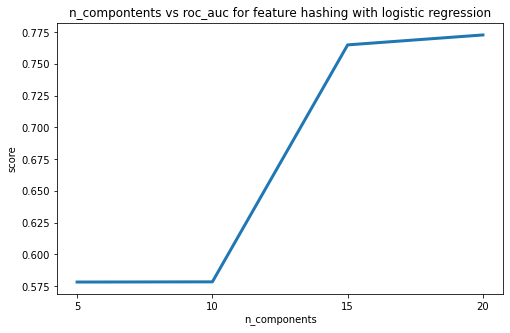

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(n_components_list_str, fh_logit_scores, linewidth=3)
plt.title('n_compontents vs roc_auc for feature hashing with logistic regression')
plt.xlabel('n_components')
plt.ylabel('score')
plt.show;

In [67]:
%%time
hashing_enc = HashingEncoder(cols = object_list_feature, n_components = 15).fit(X_train, y_train)

X_train_hashing = hashing_enc.transform(X_train.reset_index(drop = True))
X_val_hashing = hashing_enc.transform(X_val.reset_index(drop = True))

In [68]:
X_train_hashing.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
0,1,1,0,0,0,1,1,0,0,0,1,0,2,1,0,35,318891,12,0,0,40
1,0,1,0,0,0,1,1,0,0,1,2,0,0,1,1,50,485710,16,0,0,50
2,1,0,0,1,0,2,1,0,0,0,1,0,0,2,0,21,194096,10,0,0,40
3,0,1,0,0,0,1,1,0,0,0,1,0,1,1,2,42,29320,13,0,0,40
4,0,1,0,1,0,1,1,0,0,0,3,0,1,0,0,56,153451,10,0,0,35


In [69]:
%%time
hashing_logit_score = get_score(logit, X_train_hashing, y_train, X_val_hashing, y_val)
print('Logistic Regression score with feature hashing:', hashing_logit_score)

Logistic Regression score with feature hashing: 0.7648744438089153
CPU times: user 543 ms, sys: 280 ms, total: 823 ms
Wall time: 436 ms


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [70]:
%%time
hashing_rf_score = get_score(rf, X_train_hashing, y_train, X_val_hashing, y_val)
print('Random Forest score with feature hashing:', hashing_rf_score)

Random Forest score with feature hashing: 0.8883784847832061
CPU times: user 2.24 s, sys: 13.7 ms, total: 2.25 s
Wall time: 2.26 s


# Binary Encoding:

In [71]:
from category_encoders import BinaryEncoder

In [72]:
# Create example dataframe with numbers ranging from 1 to 5:
example_df = pd.DataFrame([1,2,3,4,5], columns=['example'])
example_df

,example
0,1
1,2
2,3
3,4
4,5


In [74]:
example_binary = BinaryEncoder(cols=['example']).fit_transform(example_df)
example_binary

,example_0,example_1,example_2,example_3
0,0,0,0,1
1,0,0,1,0
2,0,0,1,1
3,0,1,0,0
4,0,1,0,1


In [75]:
binary_enc = BinaryEncoder(cols = object_list_feature).fit(X_train, y_train)

In [76]:
X_train_binary = binary_enc.transform(X_train.reset_index(drop = True))
X_val_binary = binary_enc.transform(X_val.reset_index(drop = True))

In [77]:
print('Features after Binary Encoding: \n', X_train_binary.shape[1])

Features after Binary Encoding: 
 41


In [78]:
X_train_binary.head()

,age,workclass_0,workclass_1,workclass_2,workclass_3,fnlwgt,education_0,education_1,education_2,education_3,education_4,education.num,marital.status_0,marital.status_1,marital.status_2,marital.status_3,occupation_0,occupation_1,occupation_2,occupation_3,occupation_4,relationship_0,relationship_1,relationship_2,relationship_3,race_0,race_1,race_2,race_3,sex_0,sex_1,capital.gain,capital.loss,hours.per.week,native.country_0,native.country_1,native.country_2,native.country_3,native.country_4,native.country_5,native.country_6
0,35,0,0,0,1,318891,0,0,0,0,1,12,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,40,0,0,0,0,0,0,1
1,50,0,0,1,0,485710,0,0,0,1,0,16,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,50,0,0,0,0,0,0,1
2,21,0,0,1,0,194096,0,0,0,1,1,10,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,1,0,0,40,0,0,0,0,0,0,1
3,42,0,0,1,0,29320,0,0,1,0,0,13,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,1,0,0,0,40,0,0,0,0,0,0,1
4,56,0,0,0,1,153451,0,0,0,1,1,10,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,35,0,0,0,0,0,0,1


In [79]:
%%time
binary_logit_score = get_score(logit, X_train_binary, y_train, X_val_binary, y_val)
print('Logistic Regression score with binary encoding:', binary_logit_score)

Logistic Regression score with binary encoding: 0.5786172435537134
CPU times: user 409 ms, sys: 215 ms, total: 624 ms
Wall time: 343 ms


In [80]:
%%time
binary_rf_score = get_score(rf, X_train_binary, y_train, X_val_binary, y_val)
print('Random Forest score with binary encoding:', binary_rf_score)

Random Forest score with binary encoding: 0.9048561228271306
CPU times: user 2.27 s, sys: 9.47 ms, total: 2.28 s
Wall time: 2.29 s


# Target Encoding:

In [81]:
from category_encoders import TargetEncoder

In [82]:
df

,color,outcome
0,a,1
1,c,2
2,a,0
3,a,0
4,b,0
5,b,1


In [83]:
TargetEncoder(cols = ['color']).fit_transform(X, y1)

,color
0,0.37
1,0.67
2,0.37
3,0.37
4,0.54
5,0.54


In [84]:
y_train[y_train == '<=50K'] = 0
y_train[y_train == '>50K'] = 1
y_train = y_train.astype('int')

In [86]:
targ_enc = TargetEncoder(cols = object_list_feature, smoothing = 8, min_samples_leaf = 5).fit(X_train, y_train)

In [87]:
X_train_te = targ_enc.transform(X_train.reset_index(drop = True))
X_val_te = targ_enc.transform(X_val.reset_index(drop = True))

In [88]:
X_train_te.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,35,0.27,318891,0.26,12,0.07,0.47,0.10,0.26,0.11,0,0,40,0.25
1,50,0.21,485710,0.69,16,0.11,0.44,0.10,0.26,0.11,0,0,50,0.25
2,21,0.21,194096,0.19,10,0.04,0.04,0.02,0.26,0.11,0,0,40,0.25
3,42,0.21,29320,0.41,13,0.45,0.44,0.45,0.26,0.31,0,0,40,0.25
4,56,0.27,153451,0.19,10,0.11,0.13,0.10,0.26,0.11,0,0,35,0.25


In [89]:
X_train_te["sex"].value_counts()

0.31    10879
0.11     5401
Name: sex, dtype: int64

In [96]:
%%time
target_enc_logit_score = get_score(logit, X_train_te, y_train, X_val_te, y_val)
print('Logistic Regression score with target encoding:', target_enc_logit_score)

Logistic Regression score with target encoding: 0.5790293469980332
CPU times: user 312 ms, sys: 191 ms, total: 503 ms
Wall time: 282 ms


In [92]:
%%time
target_enc_rf_score = get_score(rf, X_train_te, y_train, X_val_te, y_val)
print('Random Forest score with target encoding:', target_enc_rf_score)

Random Forest score with target encoding: 0.9108304672624132
CPU times: user 2.04 s, sys: 5.75 ms, total: 2.05 s
Wall time: 2.05 s


# Weight Of Evidence (WOE):

In [100]:
from category_encoders import WOEEncoder

In [98]:
y_train[y_train == '<=50K'] = 0
y_train[y_train == '>50K'] = 1
y_train = y_train.astype('int')

In [99]:
woe_enc = WOEEncoder(cols = object_list_feature, random_state = 17).fit(X_train, y_train)

In [101]:
X_train_woe = woe_enc.transform(X_train.reset_index(drop = True))
X_val_woe = woe_enc.transform(X_val.reset_index(drop = True))

In [102]:
X_train_woe.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,35,0.14,318891,0.10,12,-1.34,1.04,-1.02,0.08,-0.97,0,0,40,0.03
1,50,-0.15,485710,1.95,16,-0.98,0.93,-1.02,0.08,-0.97,0,0,50,0.03
2,21,-0.15,194096,-0.30,10,-1.91,-1.93,-2.98,0.08,-0.97,0,0,40,0.03
3,42,-0.15,29320,0.78,13,0.94,0.93,0.94,0.08,0.33,0,0,40,0.03
4,56,0.14,153451,-0.30,10,-0.98,-0.72,-1.02,0.08,-0.97,0,0,35,0.03


In [103]:
woe_logit_score = get_score(logit, X_train_woe, y_train, X_val_woe, y_val)
print('Logistic Regression score with woe encoding:', woe_logit_score)

Logistic Regression score with woe encoding: 0.5774897159845459


In [104]:
%%time
woe_rf_score = get_score(rf, X_train_woe, y_train, X_val_woe, y_val)
print('Random Forest score with woe encoding:', woe_rf_score)

Random Forest score with woe encoding: 0.9116343496020516
CPU times: user 2.12 s, sys: 2.85 ms, total: 2.12 s
Wall time: 2.12 s


# Пора сравнить

In [105]:
score_lr = [baseline_logit_score, onehot_logit_score, hashing_logit_score, binary_logit_score, target_enc_logit_score, woe_logit_score]
score_rf = [baseline_rf_score, onehot_rf_score, hashing_logit_score, binary_rf_score, target_enc_rf_score, woe_rf_score]
methods = ['Baseline', 'One-Hot Encoding', 'Feature Hashing', 'Binary Encoding', 'Target Encoding', 'Weight Of Evidence']

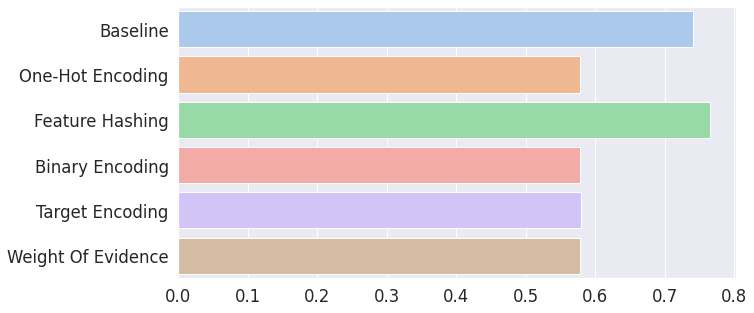

In [106]:
sns.set(font_scale = 1.5)
f, ax = plt.subplots(figsize=(10, 5))
sns.barplot(y = methods, x = score_lr, palette = 'pastel', orient = 'h');

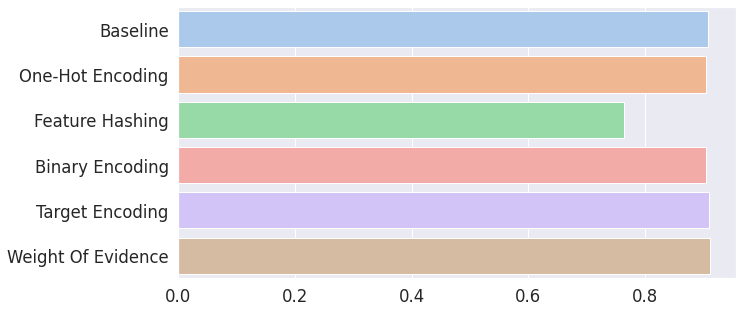

In [107]:
sns.set(font_scale = 1.5)
f, ax = plt.subplots(figsize=(10, 5))
sns.barplot(y = methods, x = score_rf, palette = 'pastel', orient = 'h');